In [3]:
%load_ext autoreload

%autoreload 2


In [5]:
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import yfinance as yf
from tqdm import tqdm

while 'notebooks' in os.getcwd():
    os.chdir("..")
    
from src.preprocessing.finbert.get_news import get_news, \
    filter_news_with_name, save_company_news_df,\
    read_company_news_df
from src.preprocessing.finbert.sentiment import generate_sentiment_from_title

api_key = '64d11b117233d0.77790833'

In [6]:
from transformers import BertTokenizer, BertForSequenceClassification

finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

## Data acquisition

In [4]:
start_year = 2019
end_year = 2023
stock = "TSLA"

tesla_news, tesla_complete = get_news(stock)

100%|██████████| 12/12 [00:58<00:00,  4.89s/it]


In [6]:
len(tesla_complete)

19785

In [8]:
news_with_tesla = filter_news_with_name(tesla_complete, 'Tesla')

In [10]:
len(news_with_tesla)

9168

In [12]:
sentiment_tesla = generate_sentiment_from_title(
    news_with_tesla,
    tokenizer,
    finbert
)

  0%|          | 0/9168 [00:00<?, ?it/s]

100%|██████████| 9168/9168 [11:17<00:00, 13.54it/s]


In [18]:
tesla_df = pd.DataFrame(news_with_tesla)[["date","title","content"]]

In [20]:
tesla_df["sentiment"] = sentiment_tesla

In [23]:
save_company_news_df(tesla_df,
                     "tesla")

## Price analysis

In [7]:
tesla_df = read_company_news_df("tesla")

In [8]:
tesla_prices = yf.download(
    'TSLA',
    start='2019-12-30',
    end='2022-12-30'
)

[*********************100%%**********************]  1 of 1 completed


In [9]:
tesla_prices.index = pd.to_datetime(tesla_prices.index)

In [10]:
tesla_prices

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-30,28.586000,28.600000,27.284000,27.646667,27.646667,188796000
2019-12-31,27.000000,28.086000,26.805332,27.888666,27.888666,154285500
2020-01-02,28.299999,28.713333,28.114000,28.684000,28.684000,142981500
2020-01-03,29.366667,30.266666,29.128000,29.534000,29.534000,266677500
2020-01-06,29.364668,30.104000,29.333332,30.102667,30.102667,151995000
...,...,...,...,...,...,...
2022-12-22,136.000000,136.630005,122.260002,125.349998,125.349998,210090300
2022-12-23,126.370003,128.619995,121.019997,123.150002,123.150002,166989700
2022-12-27,117.500000,119.669998,108.760002,109.099998,109.099998,208643400


In [11]:
tesla_df["date"] = pd.to_datetime(tesla_df["date"])
tesla_df["date"] = tesla_df["date"].dt.date

In [12]:
tesla_df = tesla_df\
    .drop_duplicates(subset = "title")

In [13]:
tesla_df["sentiment_count"] = tesla_df["sentiment"].map({
    "neutral": 0 ,
    "positive" : 1,
    "negative" : -1
})

In [15]:
tesla_sentiment = tesla_df[["sentiment_count", "date"]]\
    .groupby("date")\
    .mean()

In [16]:
tesla_sentiment

,sentiment_count
date,
2019-01-02,0.000000
2019-01-19,0.000000
2019-01-30,0.000000
2019-02-04,0.000000
2019-02-19,1.000000
...,...
2022-12-28,0.054054
2022-12-29,0.257143
2022-12-30,-0.318182


In [17]:
tesla_sentiment.index = pd.to_datetime(tesla_sentiment.index)

<AxesSubplot:xlabel='date'>

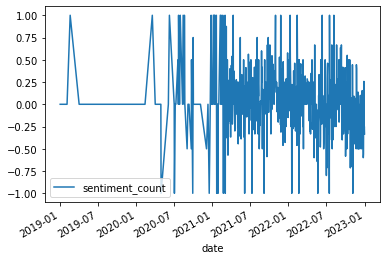

In [18]:
tesla_sentiment.plot()

In [19]:
from sklearn.preprocessing import MinMaxScaler

In [20]:
scaler = MinMaxScaler()
prices_norm = scaler.fit_transform(
    tesla_prices[["Close"]]
)

In [21]:
prices_norm_df = pd.DataFrame(
    prices_norm,
    index = tesla_prices.index
)\
    .rename(columns = {
        0: "price"
    })

In [22]:
prices_norm_df

,price
Date,
2019-12-30,0.009239
2019-12-31,0.009866
2020-01-02,0.011927
2020-01-03,0.014130
2020-01-06,0.015604
...,...
2022-12-22,0.262430
2022-12-23,0.256729
2022-12-27,0.220319


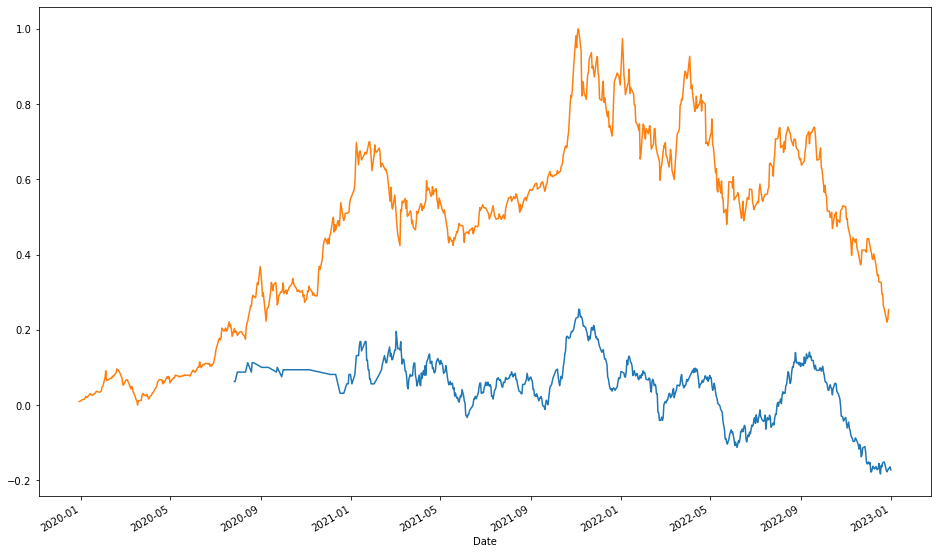

In [26]:
plt.figure(figsize = (16,10))
tesla_sentiment\
    .sentiment_count\
    .rolling(40)\
    .mean()\
    .plot()

prices_norm_df\
    .price\
    .plot()
plt.show()

In [27]:
prices_norm_df.price.corr(
    tesla_sentiment\
        .sentiment_count\
        .rolling(40)\
        .mean()
)

0.5180441873689491

In [28]:
ma_40 = tesla_sentiment\
    .sentiment_count\
    .rolling(40)\
    .mean()

ma_20 = tesla_sentiment\
    .sentiment_count\
    .rolling(20)\
    .mean()

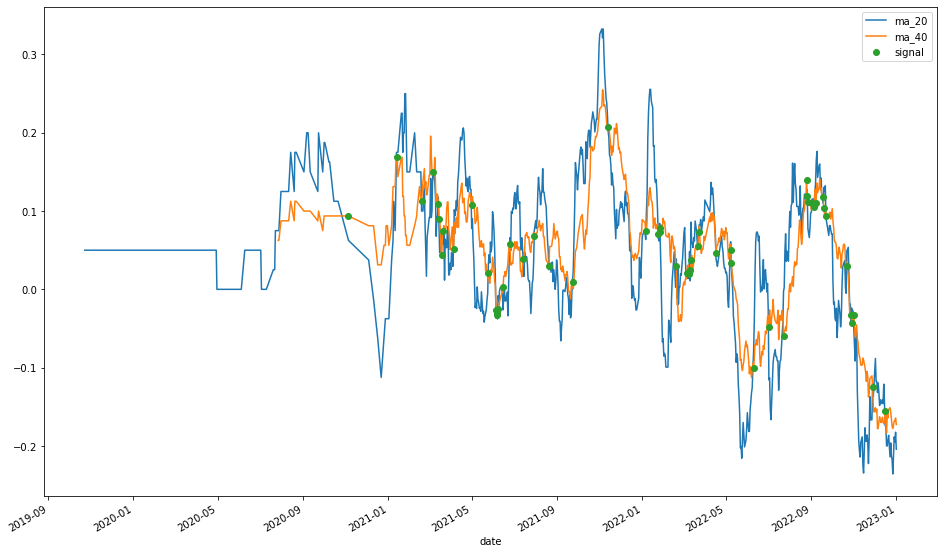

In [44]:
plt.figure(figsize=(16,10))

ma_20.plot(label = "ma_20")
ma_40.plot(label = "ma_40")
ma_40[signal == 0].plot(
    label = "signal",
    marker = "o",
    linestyle = "None"
)

plt.legend()
plt.show()

In [37]:
signal = (ma_20 - ma_40)\
    .apply(lambda x : np.sign(x))\
    .rolling(2)\
    .sum()

In [74]:
buy = ma_20[signal == 0 ] - ma_40[signal == 0] < 0
sell = ma_20[signal == 0 ] - ma_40[signal == 0] > 0

In [75]:
idx = prices_norm_df.index\
    .union(buy.index)\
    .union(sell.index)

In [76]:
idx

DatetimeIndex(['2019-12-30', '2019-12-31', '2020-01-02', '2020-01-03',
               '2020-01-06', '2020-01-07', '2020-01-08', '2020-01-09',
               '2020-01-10', '2020-01-13',
               ...
               '2022-12-15', '2022-12-16', '2022-12-19', '2022-12-20',
               '2022-12-21', '2022-12-22', '2022-12-23', '2022-12-27',
               '2022-12-28', '2022-12-29'],
              dtype='datetime64[ns]', length=776, freq=None)

In [77]:
buy = buy.reindex(idx)\
    .fillna(False)

sell = sell.reindex(idx)\
    .fillna(False)

In [78]:
prices_norm_plot = prices_norm_df\
    .reindex(idx)

In [79]:
prices_norm_plot.ffill(inplace=True)

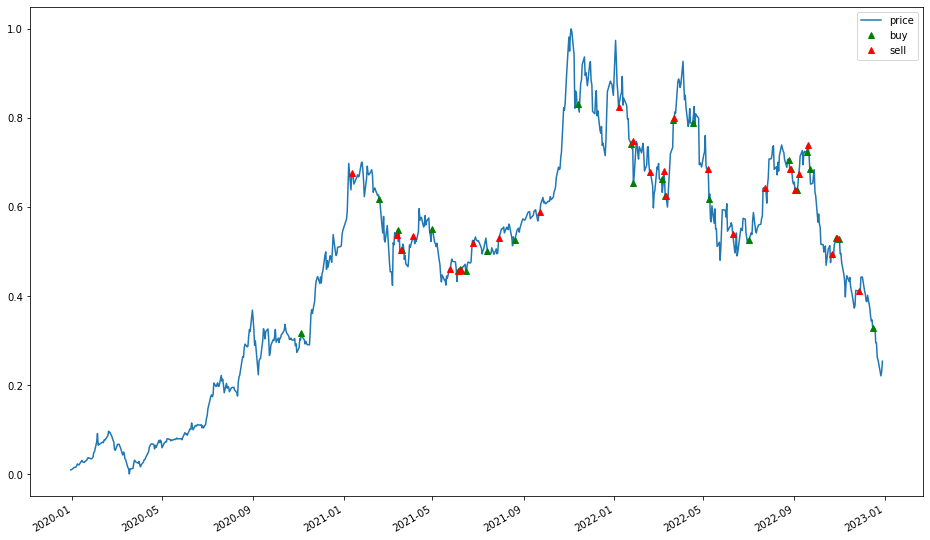

In [80]:
plt.figure(figsize=(16,10))
prices_norm_plot\
    .price\
    .plot()

prices_norm_plot[buy]\
    .price\
    .plot(
        color = "green",
        marker = "^",
        linestyle = "None",
        label = "buy"
    )

# sell_dates = sell.index
prices_norm_plot[sell]\
    .price\
    .plot(
        color = "red",
        marker = "^",
        linestyle = "None",
        label = "sell"
    )

plt.legend()
plt.show()

In [39]:
signal[signal == 0]

date
2020-11-05    0.0
2021-01-13    0.0
2021-02-18    0.0
2021-03-07    0.0
2021-03-14    0.0
2021-03-15    0.0
2021-03-19    0.0
2021-03-21    0.0
2021-04-05    0.0
2021-05-01    0.0
2021-05-25    0.0
2021-06-05    0.0
2021-06-06    0.0
2021-06-07    0.0
2021-06-08    0.0
2021-06-15    0.0
2021-06-25    0.0
2021-07-14    0.0
2021-07-30    0.0
2021-08-20    0.0
2021-09-23    0.0
2021-11-13    0.0
2022-01-07    0.0
2022-01-24    0.0
2022-01-26    0.0
2022-01-27    0.0
2022-02-19    0.0
2022-03-06    0.0
2022-03-09    0.0
2022-03-11    0.0
2022-03-12    0.0
2022-03-22    0.0
2022-03-23    0.0
2022-04-17    0.0
2022-05-08    0.0
2022-05-09    0.0
2022-06-10    0.0
2022-07-02    0.0
2022-07-23    0.0
2022-08-25    0.0
2022-08-26    0.0
2022-08-27    0.0
2022-09-02    0.0
2022-09-05    0.0
2022-09-07    0.0
2022-09-18    0.0
2022-09-19    0.0
2022-09-22    0.0
2022-10-22    0.0
2022-10-28    0.0
2022-10-29    0.0
2022-11-01    0.0
2022-11-28    0.0
2022-12-16    0.0
Name: sentiment_count, 

In [101]:
prices_norm_plot["position"] = np.nan

In [102]:
prices_norm_plot.loc[buy[buy].index, "position"] = 1
prices_norm_plot.loc[sell[sell].index, "position"] = 0


In [108]:
positions_df = prices_norm_plot\
    .ffill()\
    .fillna(1)

In [155]:
positions_df["real_price"] = tesla_prices\
    .Close\
    .reindex(idx)\
    .ffill()

In [156]:
price = positions_df["real_price"]
 

In [167]:
price

2019-12-30     27.646667
2019-12-31     27.888666
2020-01-02     28.684000
2020-01-03     29.534000
2020-01-06     30.102667
                 ...    
2022-12-22    125.349998
2022-12-23    123.150002
2022-12-27    109.099998
2022-12-28    112.709999
2022-12-29    121.820000
Name: real_price, Length: 776, dtype: float64

In [157]:
positions = positions_df["position"]

In [168]:
positions

2019-12-30    1.0
2019-12-31    1.0
2020-01-02    1.0
2020-01-03    1.0
2020-01-06    1.0
             ... 
2022-12-22    1.0
2022-12-23    1.0
2022-12-27    1.0
2022-12-28    1.0
2022-12-29    1.0
Name: position, Length: 776, dtype: float64

In [158]:
traded_price = buy * positions_df["real_price"]

In [162]:
value = (price * positions)

In [159]:
traded_price.iloc[0] = price.iloc[0]


In [183]:
last_traded_value = traded_price\
    .replace(0, np.nan)\
    .ffill()

<AxesSubplot:>

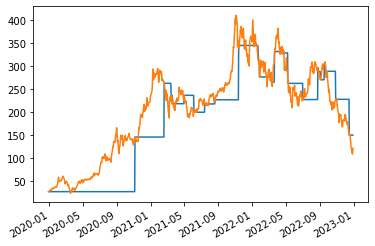

In [182]:
x.plot()
price.plot()

<AxesSubplot:>

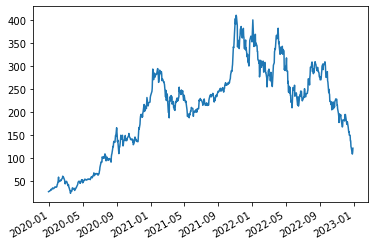

In [177]:
x.iloc[500:520]

2021-12-13    344.473328
2021-12-14    344.473328
2021-12-15    344.473328
2021-12-16    344.473328
2021-12-17    344.473328
2021-12-20    344.473328
2021-12-21    344.473328
2021-12-22    344.473328
2021-12-23    344.473328
2021-12-27    344.473328
2021-12-28    344.473328
2021-12-29    344.473328
2021-12-30    344.473328
2021-12-31    344.473328
2022-01-03    344.473328
2022-01-04    344.473328
2022-01-05    344.473328
2022-01-06    344.473328
2022-01-07    344.473328
2022-01-10    344.473328
dtype: float64

<AxesSubplot:>

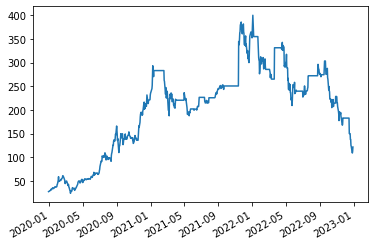

In [198]:
value\
    .replace(0, np.nan)\
    .ffill()\
    .plot()


<AxesSubplot:>

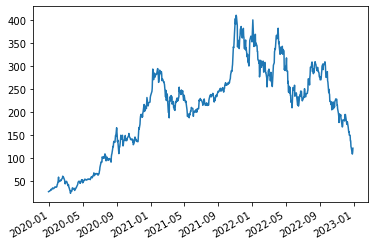

In [187]:
price.plot()

In [129]:
traded_price[traded_price != 0 ]

2020-11-05    0.316020
2021-02-18    0.617739
2021-03-15    0.549119
2021-03-21    0.503276
2021-05-01    0.550414
2021-06-05    0.455059
2021-06-07    0.460311
2021-06-15    0.455326
2021-07-14    0.501989
2021-08-20    0.525208
2021-11-13    0.830271
2022-01-24    0.740936
2022-01-27    0.653778
2022-03-06    0.661716
2022-03-11    0.624624
2022-03-22    0.796202
2022-04-17    0.788445
2022-05-09    0.617506
2022-07-02    0.526530
2022-08-25    0.704837
2022-08-27    0.684158
2022-09-05    0.637823
2022-09-18    0.723703
2022-09-22    0.685453
2022-10-28    0.529787
2022-11-01    0.527973
2022-12-16    0.326904
dtype: float64

In [123]:
cash = (traded_price * positions)\
    .cumsum()

In [100]:
prices_norm_plot

,price,position
2019-12-30,0.009239,0
2019-12-31,0.009866,0
2020-01-02,0.011927,0
2020-01-03,0.014130,0
2020-01-06,0.015604,0
...,...,...
2022-12-22,0.262430,0
2022-12-23,0.256729,0
2022-12-27,0.220319,0
2022-12-28,0.229674,0


In [109]:
median_sentiment = tesla_sentiment\
    .dropna()

In [122]:
tesla_sentiment = tesla_sentiment.dropna()

In [124]:
def zscore(x: pd.Series):
    return (x - x.mean())/x.std()

tesla_sentiment_zscore = zscore(tesla_sentiment)

<Axes: >

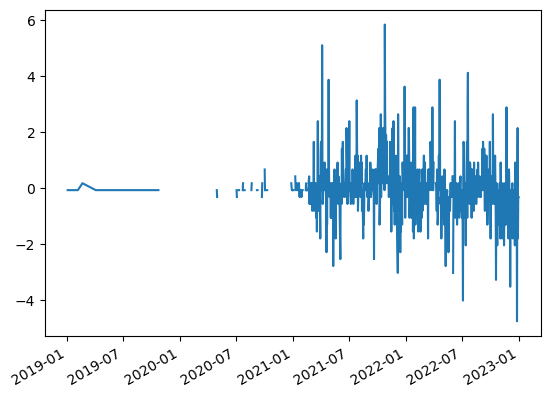

In [131]:
tesla_sentiment_zscore.plot()

In [111]:
tesla_prices


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-30,28.586000,28.600000,27.284000,27.646667,27.646667,188796000
2019-12-31,27.000000,28.086000,26.805332,27.888666,27.888666,154285500
2020-01-02,28.299999,28.713333,28.114000,28.684000,28.684000,142981500
2020-01-03,29.366667,30.266666,29.128000,29.534000,29.534000,266677500
2020-01-06,29.364668,30.104000,29.333332,30.102667,30.102667,151995000
...,...,...,...,...,...,...
2022-12-22,136.000000,136.630005,122.260002,125.349998,125.349998,210090300
2022-12-23,126.370003,128.619995,121.019997,123.150002,123.150002,166989700
2022-12-27,117.500000,119.669998,108.760002,109.099998,109.099998,208643400


In [132]:
tesla_sentiment_zscore.index

DatetimeIndex(['2019-01-02', '2019-01-19', '2019-01-30', '2019-02-04',
               '2019-02-19', '2019-04-03', '2019-04-04', '2019-04-10',
               '2019-04-11', '2019-04-24',
               ...
               '2022-12-23', '2022-12-24', '2022-12-25', '2022-12-26',
               '2022-12-27', '2022-12-28', '2022-12-29', '2022-12-30',
               '2022-12-31', '2023-01-01'],
              dtype='datetime64[ns]', length=961, freq=None)

In [113]:
tesla_prices_close = tesla_prices.Close

In [114]:
tesla_prices_close.index

DatetimeIndex(['2019-12-30', '2019-12-31', '2020-01-02', '2020-01-03',
               '2020-01-06', '2020-01-07', '2020-01-08', '2020-01-09',
               '2020-01-10', '2020-01-13',
               ...
               '2022-12-15', '2022-12-16', '2022-12-19', '2022-12-20',
               '2022-12-21', '2022-12-22', '2022-12-23', '2022-12-27',
               '2022-12-28', '2022-12-29'],
              dtype='datetime64[ns]', name='Date', length=757, freq=None)

In [126]:
new_idx = tesla_sentiment_zscore\
    .index\
    .union(tesla_prices.index)

In [127]:
tesla_sentiment_zscore = tesla_sentiment_zscore.reindex(index = new_idx)
tesla_prices_close = tesla_prices_close.reindex(index = new_idx)

In [133]:
tesla_prices_close = tesla_prices_close.ffill()
tesla_sentiment_zscore = tesla_sentiment_zscore.ffill()

<Axes: >

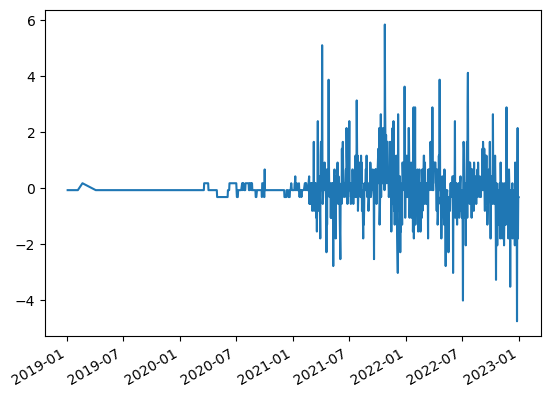

In [134]:
tesla_sentiment_zscore.plot()

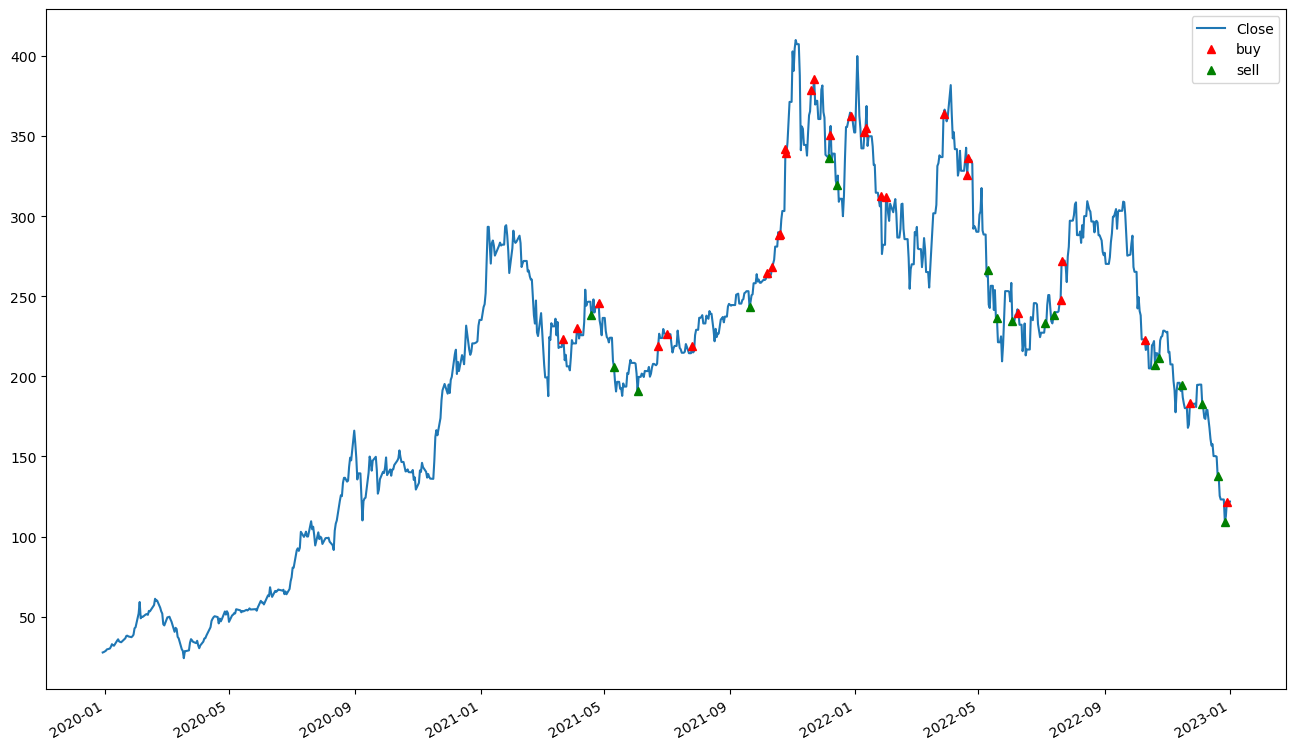

In [135]:
plt.figure(figsize=(16,10))
tesla_prices_close.plot()
tesla_prices_close[tesla_sentiment_zscore > 2].plot(
    color = 'red',
    marker = '^',
    linestyle = "None",
    label = "buy"
)

tesla_prices_close[tesla_sentiment_zscore < -2].plot(
    color = 'green',
    marker = '^',
    linestyle = "None",
    label = "sell"
)

plt.legend()
plt.show()

In [136]:
from sklearn.linear_model import LinearRegression

In [176]:
x = tesla_sentiment
y = tesla_prices_close.pct_change(-5)

In [177]:
y = y.dropna()

In [184]:
x= x.reindex_like(y)\
    .ffill()\
    .fillna(value = 0)

In [186]:
y

2019-12-30   -0.115891
2019-12-31   -0.149978
2020-01-02   -0.106120
2020-01-03   -0.073492
2020-01-06   -0.139694
                ...   
2022-12-23    0.092627
2022-12-24    0.010918
2022-12-25    0.010918
2022-12-26    0.010918
2022-12-27   -0.104416
Name: Close, Length: 936, dtype: float64

In [187]:
x

2019-12-30     0.0
2019-12-31     0.0
2020-01-02     0.0
2020-01-03     0.0
2020-01-06     0.0
              ... 
2022-12-23    -6.0
2022-12-24    -1.0
2022-12-25    -1.0
2022-12-26    -3.0
2022-12-27   -19.0
Name: sentiment_count, Length: 936, dtype: float64

In [188]:
model = LinearRegression()
model.fit(
    pd.DataFrame(x), 
    y
)

LinearRegression()

In [189]:
model.coef_

array([-0.00034375])